<a href="https://colab.research.google.com/github/SLaksh/Python/blob/main/KMeans(DifferentWay).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kmeans_blobs.csv to kmeans_blobs.csv


In [ ]:
blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


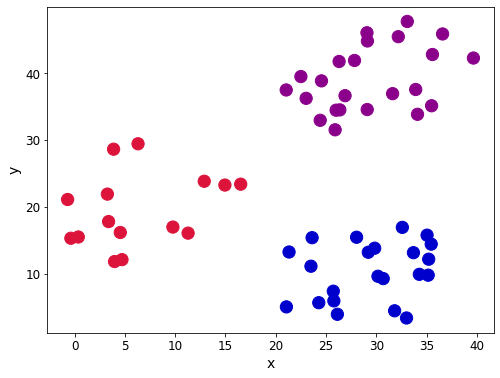

In [ ]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=blobs['x'], y=blobs['y'], s=150,
            c=blobs['cluster'].astype('category'), 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **Steps 1 and 2 - Define  and initiate the centroids**

First we need 1) to decide how many groups we have and 2) assign the initial centroids randomly. In this case let us consider , and as for the centroids, well, they have to be in the same range as the dataset itself. So one option is to randomly pick  observations and use their coordinates to initialise the centroids:

In [ ]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
df = blobs[['x','y']]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


**Step 3 - Calculate distance**

We now need to calculate the distance between each of the centroids and the data points. We will assign the data point to the centroid that gives us the minimum error. Let us create a function to calculate the root of square errors:

In [ ]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2)) 

Let us pick a data point and calculate the error so we can see how this works in practice. We will use point , which is in fact one of the centroids we picked above. As such, we expect that the error for that point and the third centroid is zero. We therefore would assign that data point to the second centroid. Let’s take a look:

In [ ]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], df.iloc[36,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 384.22
Error for centroid 1: 724.64
Error for centroid 2: 0.00


# **Step 4 - Assign centroids**

We can use the idea from Step 3 to create a function that helps us assign the data points to corresponding centroids. We will calculate all the errors associated to each centroid, and then pick the one with the lowest value for assignation:

In [ ]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

Furthermore, we can use this to update our scatter plot showing the centroids (denoted with squares) and we colour the observations according to the centroid they have been assigned to:

In [ ]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


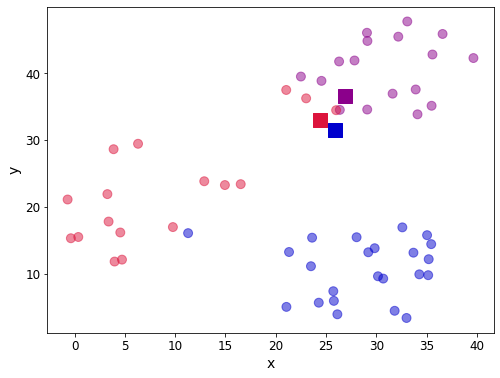

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

 if the error does not change, we can assume that the centroids have stabilised their location and we can terminate our iterations. In practice, we need to be mindful of having found a local minimum 

In [ ]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 11927659.01


# **Step 5 - Update centroid location**

Now that we have a first attempt at defining our clusters, we need to update the position of the k centroids. We do this by calculating the mean of the position of the observations assigned to each centroid

In [ ]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


We can verify that the position has been updated. Let us look again at our scatter plot:

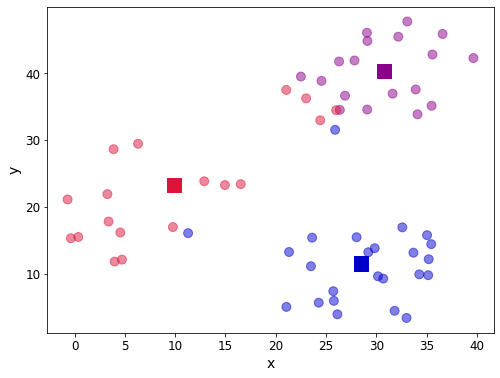

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200,
            c=[0, 1, 2], cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **Step 6 - Repeat steps 3-5**

Now we go back to calculate the distance to each centroid, assign observations and update the centroid location. This calls for a function to encapsulate the loop:

In [ ]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

We will clean our dataset first and let the algorithm run:

In [ ]:
np.random.seed(42)
df['centroid'], df['error'], centroids =  kmeans(df[['x','y']], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


And in a graphical way, let us see our clusters:

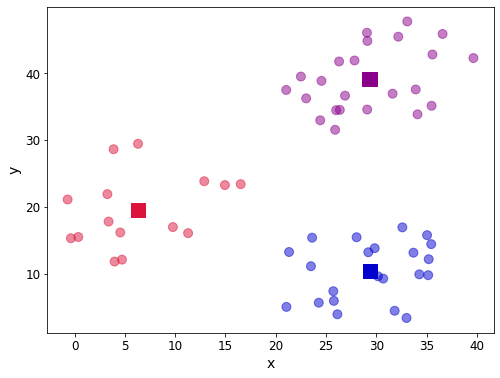

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o', 
            c=df['centroid'].astype('category'), 
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
            marker = 's', s=200, c=[0, 1, 2], 
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

 So the question about how many groups there are still remains. We can use a screen plot to help us with the error minimisation by looking at running the algorithm with a sequence  and look for the “elbow” in the plot indicating a good number of clusters to use:

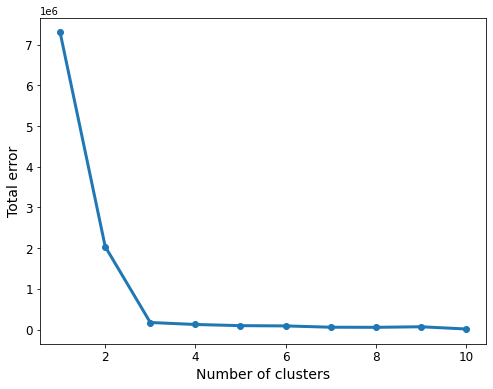

In [ ]:
err_total = []
n = 10

df_elbow = blobs[['x','y']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()